# Build a Convolutional Neural Network using TensorFlow 2.
This project was a part of **Data Science Specialization** by **E&ICT ACADEMY IIT ROORKEE** and [**CLOUDXLAB**](http://cloudxlab.com/). 


In [61]:
import numpy as np
import tensorflow as tf
print("Tensorflow version", tf.__version__)

Tensorflow version 2.1.0


In [62]:
from tensorflow import keras
print("Keras version", keras.__version__)

Keras version 2.2.4-tf


In [63]:
import matplotlib.pyplot as plt

Set the random seed for **tf** and **np** so as to reuse the same set of random variables and reproduce the results.

In [64]:
np.random.seed(42)
tf.random.set_seed(42)

### Loading the Dataset
Let's load the fashion MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set.
For more infor: https://github.com/zalandoresearch/fashion-mnist

In [65]:
fashion_mnist = keras.datasets.fashion_mnist

In [66]:
# Load and sort the data into train and test sets 
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [67]:
X_train_full.shape

(60000, 28, 28)

### Splitting the Data

Though the dataset is already split for you between a training set and a test set, it can be useful to split the training set further to have a validation set. We shall do that here.

Let's split the full training set into a validation set and a (smaller) training set. We will also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

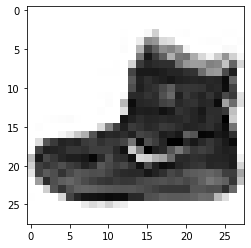

In [68]:
# Let us see an image from the dataset using plt.imshow.
plt.imshow(X_train_full[0], cmap="Greys")

In [69]:
# Let us see the class of the image.
print ("item0", y_train_full[0])

item0 9


In [70]:
# Slice the first samples from 55000 of the X_train_full store these samples in X_train.
X_train = X_train_full[:55000]

In [71]:
# Store the remaining samples from 55000 of the y_train_full to form the y_train
y_train = y_train_full[:55000]

In [72]:
# Similarly, slice the remaining samples from the X_train_full and store these samples in X_valid.
X_valid = X_train_full[55000:]

In [73]:
# Store the remaining values from y_train_full to form the y_valid.
y_valid = y_train_full[55000:]

In [74]:
# print the shapes of the train data, validation data, and test data.
print("Train data shape:",X_train.shape)
print("Validation data shape:",X_valid.shape)
print("Test data shape:",y_test.shape)

Train data shape: (55000, 28, 28)
Validation data shape: (5000, 28, 28)
Test data shape: (10000,)


### Normalising the Features

We shall now normalize the features(pixel values) of train, validation, and test sets with the mean and standard deviation values of the train data.
So first we shall calculate the mean and standard deviation values of the train data.
Then we use these values to normalize the pixel values.

**Note:**

- **np.newaxis** : Used to increase the array dimensionality by 1. Often used when we want to convert a numpy array into one higher dimensionality, like a 1D array to 2d array, or 2D array to 3D array and so on. More [here](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis)

- **numpy_array.mean()** : Compute the arithmetic mean along the specified axis. More [here](https://numpy.org/doc/stable/reference/generated/numpy.mean.html#:~:text=mean-,numpy.,otherwise%20over%20the%20specified%20axis.)

In [75]:
# Get the mean X_mean of X_train using mean() along the axis=0.
X_mean = X_train.mean(axis=0, keepdims=True)

# Get the standard deviation X_std of X_train using std() along the axis=0.
X_std = X_train.std(axis=0, keepdims=True)

# Now, normalize the X_train values as follows:
X_train = (X_train - X_mean) / X_std

# # Similarly, normalize the X_valid values as follows:
# X_valid_mean = X_valid.mean(axis=0, keepdims=True)
# X_valid_std = X_valid.std(axis=0, keepdims=True)
# X_valid = (X_valid - X_valid_mean) / X_valid_std

# # Similarly, normalize the X_test values as follows:
# X_test_mean = X_test.mean(axis=0, keepdims=True)
# X_test_std = X_test.std(axis=0, keepdims=True)
# X_test = (X_test - X_test_mean) / X_test_std


X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
# A convolutional layer, which is the first layer of our classifier we are going to build later, 
# expects the input to be 4 dimensional: (batch size, filters or channels, width, height). So 
# let us increase the dimensionality - using np.newaxis - of our data so that everything will be one batch each.
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Now let's print the shape of these features in each of the sets:
print ("Shape of features", X_train.shape, X_valid.shape, X_test.shape)

Shape of features (55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)


### Building and Fitting the Model

Let us build a Convolutional Neural Network for this classification problem.

**Note:**

- **partial** : It is a function from **functools.** It returns a function object for a given function, with the flexibility to freeze some parameters. We can either change these parameters or leave them as they are. the remaining parameters which are not frozen should be passed to the newly generated function.

- **tf.keras.layers.Conv2D** : 2D convolution layer function. It has various parameters like **kernel_size, activation, padding, filters** etc. More [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

- **tf.keras.layers.MaxPool2D** : Max pooling operation for 2D spatial data. More [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

- **tf.keras.layers.Flatten** : Flattens the input. More [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

- **tf.keras.layers.Dense** : Just your regular densely-connected NN layer. More [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

- **tf.keras.layers.Dropout** : Applies Dropout to the input.

- Since the class labels are integer indices, we use **sparse_categorical_cross entropy.** If the class labels are one-hot vectors, we could use **categorical_crossentropy.**

- For **metrics** parameter of the **model.compile**, we can mention evaluation metrics we want the model to return. Here we shall write **accuracy**.

In [83]:
from functools import partial

Make the partial function named **DefaultConv2D** using **partial** function imported from functools. We pass the keras.layers.Conv2D function and other parameters to freeze them. We could change them later.

In [84]:
DefaultConv2D = partial(keras.layers.Conv2D,
                kernel_size=3, activation='relu', padding="SAME")

Now use this DefaultConv2D along with the other layers(like keras.layers.MaxPooling2D, keras.layers.Dense, etc.) to build the classification model. Here we set input_shape as [28, 28, 1] since the size of each image is 28x28x1.

In [85]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), 
    keras.layers.MaxPooling2D(pool_size=2), 
    DefaultConv2D(filters=128),  
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

Observe here, that we changed the kernel_size(which we initially freezer to be 3) in the DefaultConv2D, and we have also mentioned other parameter values.

Use **model.compile** and compile it with loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"].

In [86]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

Use **fit** method of the model to start training on the train dataX_train, y_train. Use validation_data = (X_valid, y_valid).

In [87]:
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 115s 2ms/sample - loss: 0.7076 - accuracy: 0.7534 - val_loss: 0.3668 - val_accuracy: 0.8692
Epoch 2/3
55000/55000 [==============================] - 111s 2ms/sample - loss: 0.4181 - accuracy: 0.8583 - val_loss: 0.3194 - val_accuracy: 0.8878
Epoch 3/3
55000/55000 [==============================] - 121s 2ms/sample - loss: 0.3609 - accuracy: 0.8770 - val_loss: 0.3157 - val_accuracy: 0.8844


### Evaluating the Model Performance

Let us see how well our model has learned from the train data, by testing it on the test data.

**Note:**

- **model.evaluate(X_test, y_test)** : Returns a list with the loss(at index 0) and accuracy(at index 1) of the predictions of the **model** on **X_test.**

- **array[a:b]** : Returns the elements of **array** from index **a** till **b-1** inclusive.

- **model.predict** : Generates output predictions for the input samples. It returns the probabilities of each class for a given test sample. We consider the classification to be of that class(or of that index) whose probability of the highest.

- **np.argmax** : Returns the indices of the maximum values along an axis. More [here](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [93]:
# Check data prediction accuracy
results = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 6s 610us/sample - loss: 0.3329 - accuracy: 0.8820


In [94]:
print(results[1])

0.882


Let us see the predictions of 9 of the test samples from index 10.

In [96]:
X_new = X_test[10:20]

In [97]:
y_pred = model.predict(X_new)

In [98]:
print(np.argmax(y_pred, axis=1))

[4 5 7 3 4 1 2 4 8 0]


In [99]:
print (y_test[10:20])

[4 5 7 3 4 1 2 4 8 0]
